# APTOS 2019 Blindness Detection - Kaggle

This notebook aims to demonstrate a baseline implementation that makes use of a Convolutional Neural Net, specifically a Resnet 50 (Deep Residual Learning for Image Recognition) through transfer learning.

I have used a Pre-trained [ResNet-50 Model](https://www.kaggle.com/pytorch/resnet50/downloads/resnet50.zip/1) for PyTorch to enable a faster training period. The same has been optimized slightly to improve the score.

### Diabetic Retinopathy 

Diabetic retinopathy (DR), also known as diabetic eye disease, is a medical condition in which damage occurs to the retina due to diabetes mellitus. It is a leading cause of blindness. Diabetic retinopathy affects up to 80 percent of those who have had diabetes for 20 years or more. Diabetic retinopathy often has no early warning signs. **Retinal (fundus) photography with manual interpretation is a widely accepted screening tool for diabetic retinopathy**, with performance that can exceed that of in-person dilated eye examinations. 

The below figure shows an example of a healthy patient and a patient with diabetic retinopathy as viewed by fundus photography ([source](https://www.biorxiv.org/content/biorxiv/early/2018/06/19/225508.full.pdf)):

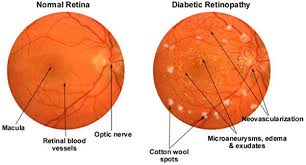

An automated tool for grading severity of diabetic retinopathy would be very useful for accerelating detection and treatment. Recently, there have been a number of attempts to utilize deep learning to diagnose DR and automatically grade diabetic retinopathy. This includes a previous [competition](https://kaggle.com/c/diabetic-retinopathy-detection) and [work by Google](https://ai.googleblog.com/2016/11/deep-learning-for-detection-of-diabetic.html). Even one deep-learning based system is [FDA approved](https://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm604357.htm). 

Clearly, this dataset and deep learning problem is quite important. 

### Competition Rules

Data description from the competition:

>You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. >Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).
>
>A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:
>
>0 - No DR
>
>1 - Mild
>
>2 - Moderate
>
>3 - Severe
>
>4 - Proliferative DR
>
>Your task is to create an automated analysis system capable of assigning a score based on this scale.

> Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. A major aim of this competition is to develop robust algorithms that can function in the presence of noise and variation.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
shutil.copy("C:/Users/sriha/Documents/Transfer Learning/resnet50/resnet50.pth", "/tmp/.cache/torch/checkpoints/")

'/tmp/.cache/torch/checkpoints/resnet50.pth'

In [5]:
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cudnn is enabled: True


### Reading data

Here I am going to open the dataset with pandas, check distribution of labels.

In [14]:
base_image_dir = Config.data_path()/'blindness'
train_dir = Config.data_path()/'blindness'/'train-jpg'
df = pd.read_csv(Config.data_path()/'blindness'/'train.csv')
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,diagnosis,path
0,2,C:\Users\sriha\.fastai\data\blindness\train-jp...
1,1,C:\Users\sriha\.fastai\data\blindness\train-jp...
2,0,C:\Users\sriha\.fastai\data\blindness\train-jp...
3,4,C:\Users\sriha\.fastai\data\blindness\train-jp...
4,0,C:\Users\sriha\.fastai\data\blindness\train-jp...
5,3,C:\Users\sriha\.fastai\data\blindness\train-jp...
6,2,C:\Users\sriha\.fastai\data\blindness\train-jp...
7,0,C:\Users\sriha\.fastai\data\blindness\train-jp...
8,0,C:\Users\sriha\.fastai\data\blindness\train-jp...
9,1,C:\Users\sriha\.fastai\data\blindness\train-jp...


In [15]:
len_df = len(df)
print(f"There are {len_df} images")

There are 3662 images


The dataset is highly imbalanced, with many samples for level 0, and very little for the rest of the levels. But in the words of Jeremy Howard from Fast AI, "Try it! It usually works" in one his deep learning tutorial.

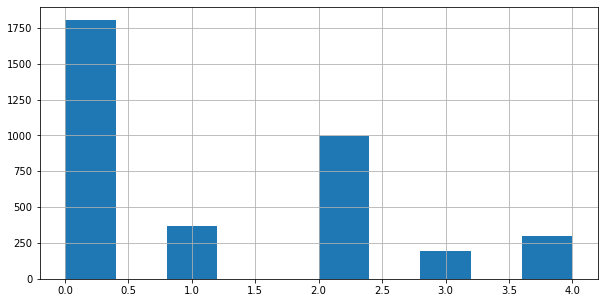

In [16]:
df['diagnosis'].hist(figsize = (10, 5))

The images are actually quite big. We will resize to a much smaller size.

In [17]:
#Setting batch size to 16 as it fits on GPU at that size
bs = 16 #smaller batch size is better for training, but may take longer
sz=224

In [28]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)

src = (ImageList.from_csv(Config.data_path()/'blindness', 'train.csv', folder='train-jpg', suffix='.png')
       .split_by_rand_pct(0.2)
         .label_from_df(cols='diagnosis',label_cls=FloatList)) #obtain labels from the level column

In [29]:
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

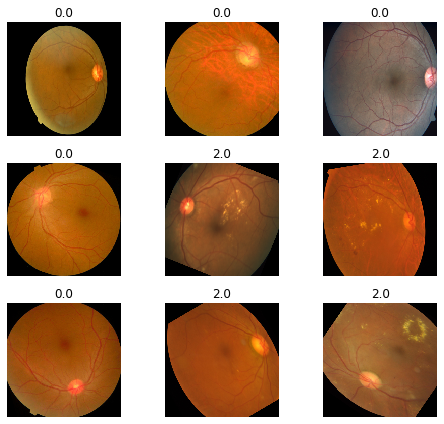

In [30]:
data.show_batch(rows=3, figsize=(7,6))

## Training (Transfer learning)

The Kaggle competition makes use of the Cohen's quadratically weighted kappa so I have that here to compare. This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fastai uses.

In [31]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')

**Training:**

We use transfer learning, where we retrain the last layers of a pretrained neural network. I use the ResNet50 architecture trained on the ImageNet dataset, which has been commonly used for pre-training applications in computer vision. Fastai makes it quite simple to create a model and train:

In [32]:
learn = cnn_learner(data, base_arch=models.resnet50, metrics = [quadratic_kappa])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 1.00E-02


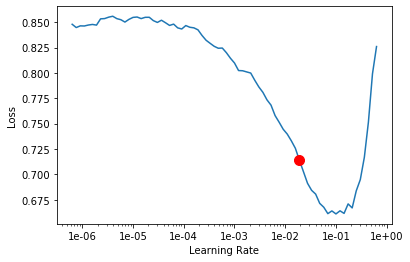

In [34]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Here we can see that the loss decreases fastest around `lr=1e-2` so that is what we will use to train:

In [37]:
learn.fit_one_cycle(4,max_lr = 1e-2)

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.980044,0.586526,0.815754,10:17
1,0.754635,0.647527,0.689027,05:23
2,0.555875,0.393489,0.852016,06:05
3,0.450979,0.393018,0.856701,06:04


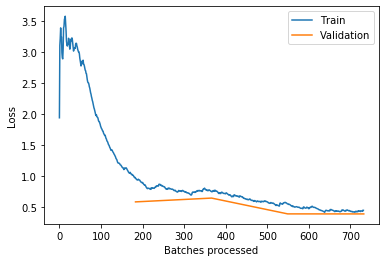

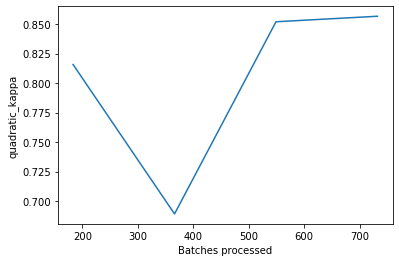

In [38]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 4.37E-06


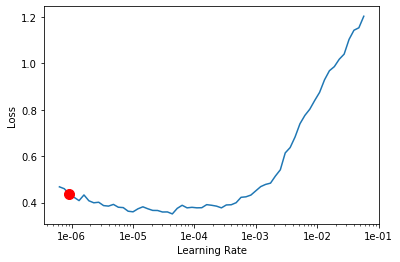

In [39]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [42]:
learn.fit_one_cycle(6, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.412025,0.390147,0.854222,05:31
1,0.388873,0.382644,0.859406,05:56
2,0.372624,0.376259,0.864265,06:13
3,0.397775,0.378721,0.865255,05:44
4,0.404129,0.389647,0.867906,05:35
5,0.413441,0.365497,0.867635,06:17


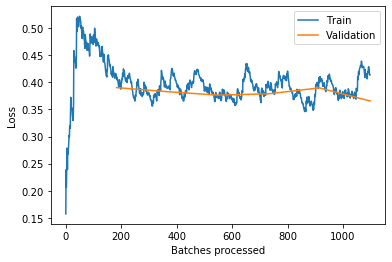

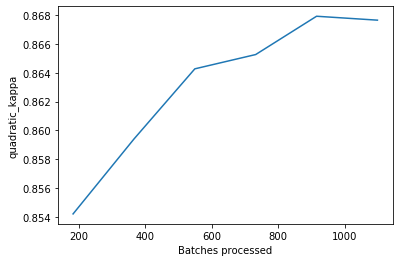

In [43]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [44]:
learn.export()
learn.save('stage-2')

Let's evaluate our model:

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

## Optimize the Metric

Optimizing the quadratic kappa metric was an important part of the top solutions in the previous competition. Thankfully, @abhishek has already provided code to do this for us. We will use this to improve the score.

In [47]:
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)

In [48]:
import numpy as np
import pandas as pd
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json

In [49]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [50]:
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])

0.8839029283643209


In [51]:
coefficients = optR.coefficients()
print(coefficients)

[0.556884 1.475508 2.328322 3.256708]


## Submission
Let's now create a submission

In [54]:
Config.data_path()/'blindness/sample_submission.csv'

WindowsPath('C:/Users/sriha/.fastai/data/blindness/sample_submission.csv')

In [55]:
sample_df = pd.read_csv(Config.data_path()/'blindness/sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [57]:
learn.data.add_test(ImageList.from_df(sample_df,Config.data_path()/'blindness',folder='test-jpg',suffix='.png'))

In [58]:
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [59]:
test_predictions = optR.predict(preds, coefficients)

In [60]:
sample_df.diagnosis = test_predictions.astype(int)
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [61]:
sample_df.to_csv('submission.csv',index=False)